In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d akkulkarni/training-handwritten-marathi-character-fusion

100% 86.0M/86.0M [00:05<00:00, 22.1MB/s]
100% 86.0M/86.0M [00:05<00:00, 16.8MB/s]


In [2]:
!unzip training-handwritten-marathi-character-fusion.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data_set/C43/015_10.jpg  
  inflating: Data_set/C43/016_01.jpg  
  inflating: Data_set/C43/016_02.jpg  
  inflating: Data_set/C43/016_03.jpg  
  inflating: Data_set/C43/016_04.jpg  
  inflating: Data_set/C43/017_01.jpg  
  inflating: Data_set/C43/017_02.jpg  
  inflating: Data_set/C43/017_03.jpg  
  inflating: Data_set/C43/017_04.jpg  
  inflating: Data_set/C43/017_05.jpg  
  inflating: Data_set/C43/017_06.jpg  
  inflating: Data_set/C43/017_07.jpg  
  inflating: Data_set/C43/017_08.jpg  
  inflating: Data_set/C43/017_09.jpg  
  inflating: Data_set/C43/017_10.jpg  
  inflating: Data_set/C43/018_01.jpg  
  inflating: Data_set/C43/018_02.jpg  
  inflating: Data_set/C43/018_03.jpg  
  inflating: Data_set/C43/018_04.jpg  
  inflating: Data_set/C43/018_05.jpg  
  inflating: Data_set/C43/018_06.jpg  
  inflating: Data_set/C43/018_07.jpg  
  inflating: Data_set/C43/018_08.jpg  
  inflating: Data_set/C43/018_09.jpg  
  inflating: 

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=None,
)

In [4]:
path = '/content/Data_set'
size = (128, 128)


train = datagen.flow_from_directory(
    path,
    target_size=size,
    batch_size=64,
    class_mode='categorical',
    subset="training",
    seed=123,
)

val = datagen.flow_from_directory(
    path,
    target_size=size,
    batch_size=64,
    class_mode='categorical',
    subset="validation",
    seed=123,
)

Found 13348 images belonging to 58 classes.
Found 3305 images belonging to 58 classes.


In [5]:
train.class_indices

{'C1': 0,
 'C10': 1,
 'C11': 2,
 'C12': 3,
 'C13': 4,
 'C14': 5,
 'C15': 6,
 'C16': 7,
 'C17': 8,
 'C18': 9,
 'C19': 10,
 'C2': 11,
 'C20': 12,
 'C21': 13,
 'C22': 14,
 'C23': 15,
 'C24': 16,
 'C25': 17,
 'C26': 18,
 'C27': 19,
 'C28': 20,
 'C29': 21,
 'C3': 22,
 'C30': 23,
 'C31': 24,
 'C32': 25,
 'C33': 26,
 'C34': 27,
 'C35': 28,
 'C36': 29,
 'C37': 30,
 'C38': 31,
 'C39': 32,
 'C4': 33,
 'C40': 34,
 'C41': 35,
 'C42': 36,
 'C43': 37,
 'C44': 38,
 'C45': 39,
 'C46': 40,
 'C47': 41,
 'C48': 42,
 'C49': 43,
 'C5': 44,
 'C50': 45,
 'C51': 46,
 'C52': 47,
 'C53': 48,
 'C54': 49,
 'C55': 50,
 'C56': 51,
 'C57': 52,
 'C58': 53,
 'C6': 54,
 'C7': 55,
 'C8': 56,
 'C9': 57}

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.models import Sequential

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3),
)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense((len(train.class_indices)), activation='softmax'))


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)


model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                         

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=3,
    verbose=1)


history = model.fit(train,
          validation_data=val,
          epochs=30,
          verbose=1,
          callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/30
209/209 [==============================] - ETA: 0s - loss: 4.0843 - accuracy: 0.0515
Epoch 1: val_accuracy improved from -inf to 0.00575, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/209 [==============================] - 108s 352ms/step - loss: 4.0843 - accuracy: 0.0515 - val_loss: 17.1176 - val_accuracy: 0.0057 - lr: 0.0010
Epoch 2/30
209/209 [==============================] - ETA: 0s - loss: 3.2600 - accuracy: 0.1400
Epoch 2: val_accuracy improved from 0.00575 to 0.00605, saving model to model.h5
209/209 [==============================] - 63s 303ms/step - loss: 3.2600 - accuracy: 0.1400 - val_loss: 24.7812 - val_accuracy: 0.0061 - lr: 0.0010
Epoch 3/30
209/209 [==============================] - ETA: 0s - loss: 2.4951 - accuracy: 0.2818
Epoch 3: val_accuracy improved from 0.00605 to 0.01210, saving model to model.h5
209/209 [==============================] - 67s 318ms/step - loss: 2.4951 - accuracy: 0.2818 - val_loss: 10.7931 - val_accuracy: 0.0121 - lr: 0.0010
Epoch 4/30
209/209 [==============================] - ETA: 0s - loss: 1.8982 - accuracy: 0.4140
Epoch 4: val_accuracy improved from 0.01210 to 0.48351, saving model to model.h5
209/209 [===============

In [8]:
with open('model.json', 'w') as json_file:
    json_file.write(model.to_json())

model.save_weights('model.h5')


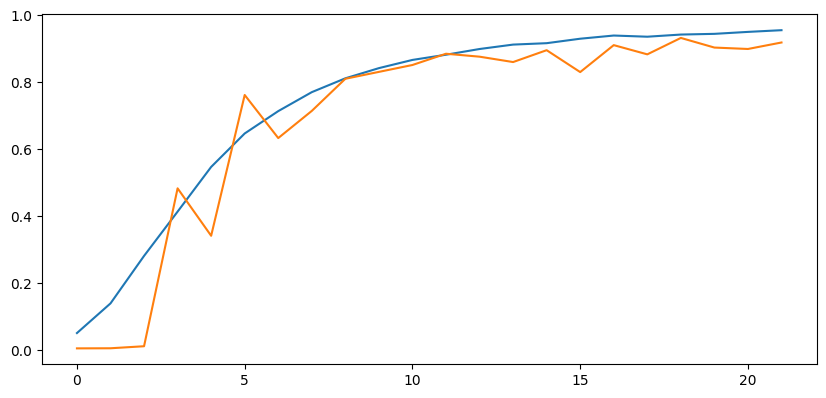

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.show()

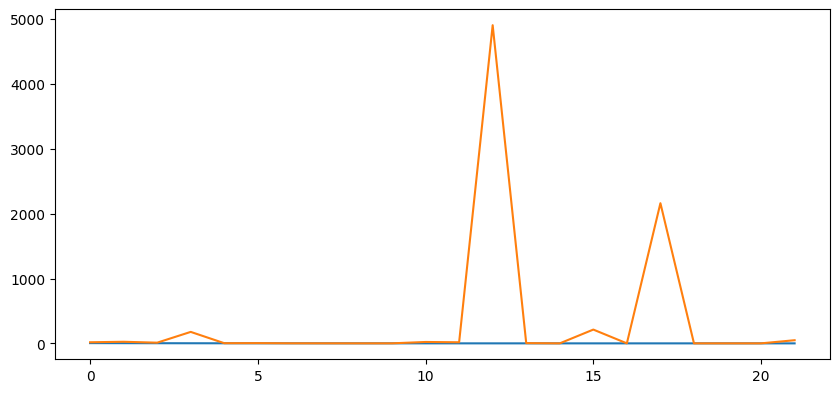

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.show()

In [13]:
accu = model.evaluate(val)[1]
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

52/52 [==============================] - 5s 88ms/step - loss: 48.6492 - accuracy: 0.9189
Final Test Acccuracy = 91.891


52/52 [==============================] - 6s 106ms/step


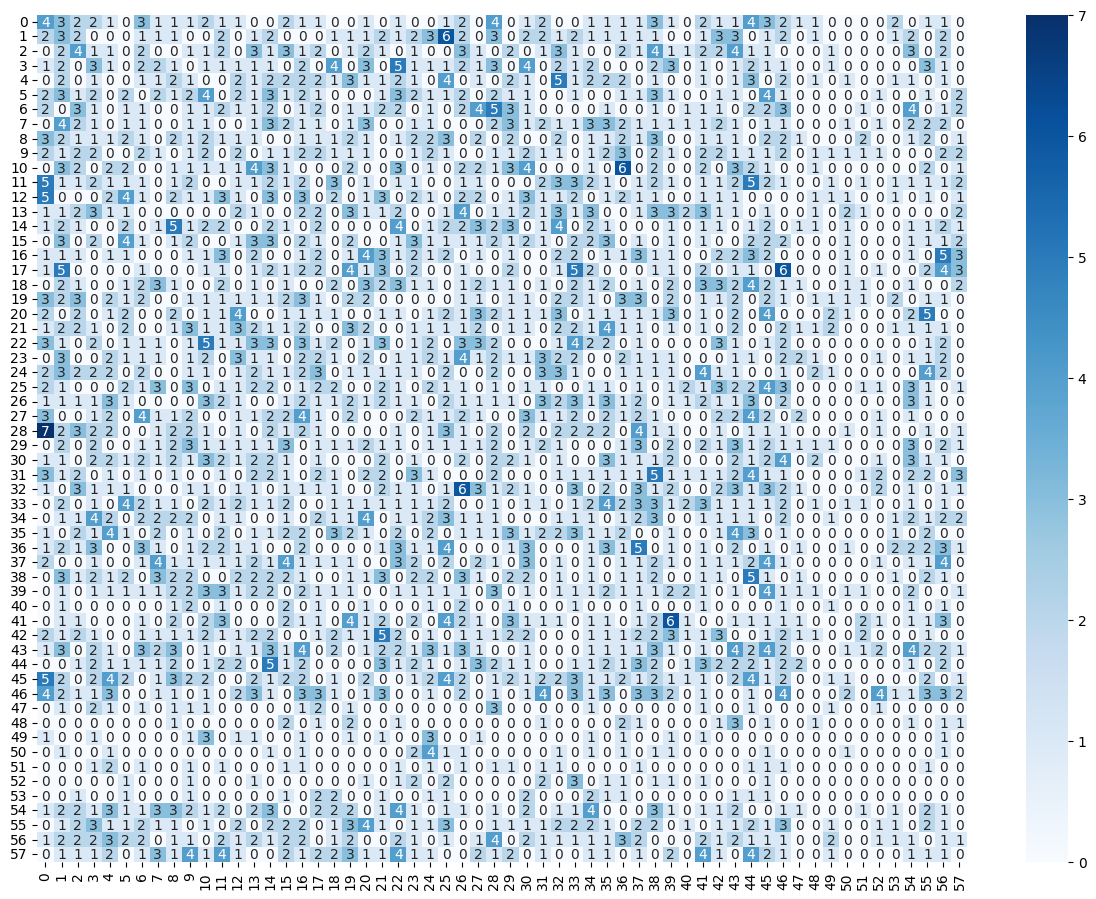

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(val)
y_pred_int = y_pred.argmax(axis=1)

plt.figure(figsize = (15,11))
sns.heatmap(confusion_matrix(val.classes, y_pred_int), annot = True,fmt="d",cmap = "Blues")
plt.show()